In [10]:
from simulation_utils import default_params, community
from analysis_utils import *
from multiprocessing import Pool
from functools import partial
from matplotlib import pyplot as plt
from time import time

# helper function for parallel running
def simulate_worker(i, n_days, structure, structure_params, params, verbose=1):
    start_time = time()
    com = community(structure = structure, struct_params = struct_params,params=params)
    stat, nodes = com.simulator(n_days)
    if verbose:
        print(f'simulation Round {i}, time lapsed: {time()-start_time:.2f}')
    return stat, nodes

# comparing workers
def compare_worker(val_name, val_range, structure_params, base_params, 
                   n_simulation = 8, days = 90):
    start_time = time()
    params = base_params.copy()
    results = []
    for v in val_range:
        params[val_name] = v
        with Pool(8) as p:
            result = list(p.map(partial(simulate_worker, 
                          n_days = days, structure = 'ws_network', 
                          structure_params = struct_params, params = params, 
                          verbose=0), list(range(n_simulation))))
        results.append(average_stats(result))
    print(f'Completed in {time()-start_time:.2f}s')
    return results
    
# structure parameter is estimated from 
struct_params = [50000, 35, 0.7]    # 50000 residences, average degree 35, casual link 0.7
n_simulation = 40                   # monte carlo repeation                       

## Part 0: Finding the natural infection rate with R_0

In [11]:
params = default_params.copy()
# list of betas to explore
bs = np.linspace(0.01,0.02,11)
days = 90
res_r0 = compare_worker('b',bs, struct_params, params,
                        n_simulation = n_simulation, days = days)

Completed in 2507.14s


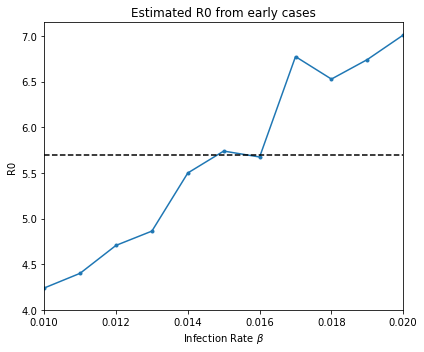

In [12]:
# plot results
fig, ax = plt.subplots(figsize = (6,5))
plot_max_compare(ax, bs, res_r0, 'R', x_name=r'Infection Rate $\beta$',
                 y_name = 'R0',title = f'Estimated R0 from early cases')
ax.axhline(5.7,ls ='--',color='k')
ax.set_ylim(bottom = 4)
fig.tight_layout()

## Part 1: Virus spread without pandenmic control (SEIR)

In [ ]:
title = 'Without Pandemic Control'
params = default_params.copy()      # initialize prameter
with Pool(8) as p:
    result = list(p.map(partial(simulate_worker, 
                  n_days = 90, structure = 'ws_network', 
                  structure_params = struct_params, params = params, 
                  verbose =0), list(range(n_simulation))))

In [ ]:
# plot result
fig, ax = plt.subplots(1,2, figsize = (12,4))
plot_cases(ax[0], result,title)
plot_rs(ax[1],result,title)
fig.tight_layout()

## Part 2 Vaccine amount required for herd immunity (SEIR)

In [ ]:
params = default_params.copy()
params['pc'] = 0.95 # Assign effectiveness of vacccine
prs = np.linspace(0,1,21)
days = 90
# making compare
res_vaccine = compare_worker('pr',prs, struct_params, params, days = days)

In [ ]:
# plot results
fig, ax = plt.subplots(1,2,figsize = (13,5))
plot_max_compare(ax[0], prs, res_vaccine, 'accumulated_cases', x_name='Fraction of Vaccination',
                 y_name = 'Fraction of Population',title = f'Accumulated cases after {days} days')
plot_max_compare(ax[1], prs, res_vaccine, 'symptomatic_cases', x_name='Fraction of Vaccination',
                 y_name = 'Fraction of Population',title = f'Max symptomatic cases in {days} days')
fig.tight_layout()

## Part 3: Ideal Pandemic control without Vaccine

In [ ]:
days = 180
title = 'Ideal Pandemic Control without Vaccine'
params = default_params.copy()
params['pc'] = 0.67 # Mask effective ness Chu, D. K. et al. Lancet 395, 1973–1987 (2020).
params['pr'] = 1.0  # Mandatory mask wearing
params['g']  = 1.0  # Fast medical reaction and mandatory isolation
params['qt'] = 1.0  # Every Cases has been identified (massive test)

with Pool(8) as p:
    result = list(p.map(partial(simulate_worker, 
                  n_days = days, structure = 'ws_network', 
                  structure_params = struct_params, params = params, 
                  verbose=0), list(range(n_simulation))))

In [ ]:
# plot result
fig, ax = plt.subplots(1,3, figsize = (18,4))
plot_cases(ax[0], result,title)
plot_quarantine(ax[1], result,title)
plot_rs(ax[2],result,title)
fig.tight_layout()

## Part 4: Generic pandemic control without Lockdown (an example)

In [ ]:
days = 180

title = 'General Pandemic Control without Lockdown'
params = default_params.copy()
params['pc'] = 0.67 # Mask effectiveness Chu, D. K. et al. Lancet 395, 1973–1987 (2020).
params['pr'] = 0.75 # Rate of Volunteer mask wearing: https://nyti.ms/3hdCzzP
params['g']  = 0.50 # Every day the 50% of infected people will go isolation
params['qt'] = 0.50 # 50% of the infection is detected
# general parameters
gen_params = params
with Pool(8) as p:
    result = list(p.map(partial(simulate_worker, 
                  n_days = days, structure = 'ws_network', 
                  structure_params = struct_params, params = gen_params, 
                  verbose=0), list(range(n_simulation))))

In [ ]:
# plot result
fig, ax = plt.subplots(1,3, figsize = (18,4))
plot_cases(ax[0], result,title)
plot_quarantine(ax[1], result,title)
plot_rs(ax[2],result,title)
fig.tight_layout()

## Part 5: Pandemic Control Factors Lookout

In [ ]:
# Factor of mask wearing rate
results = {}
start_time = time()
days = 180 # run for 180 days

# comparing work
for name in ['pr','g','qt']:
    print(f'Running for {name}:', end = ' ')
    params = gen_params.copy()
    val = np.linspace(0,1,21)
    # making compare
    results[name] = (val, compare_worker(name, val, struct_params, params, days = days))

In [ ]:
# plot results
fig, ax = plt.subplots(2,3,figsize = (12,6))
# xlabel mapping
xlabels = {'pr': 'Mask Rate','g': 'Isolation Rate','qt':'Test Cover Rate'}
# plot result
for i, name in enumerate(results.keys()):
    plot_max_compare(ax[0,i], results[name][0], results[name][1], 'accumulated_cases', x_name=xlabels[name],
                     y_name = 'Fraction of Population',title = f'Accumulated cases after {days} days')
    plot_max_compare(ax[1,i], results[name][0], results[name][1], 'symptomatic_cases', x_name=xlabels[name],
                     y_name = 'Fraction of Population',title = f'Max symptomatic cases in {days} days')
fig.tight_layout()

## Part 6: General Pandemic Control with Lockdown

In [ ]:
days = 180

title = 'General Pandemic Control with Lockdown'
params = gen_params.copy()
params['lt'] = 0.01 # lockdown threshold for total symptomatic cases
params['ls'] = 0.50 # 50% people is going quarantine
with Pool(8) as p:
    result = list(p.map(partial(simulate_worker, 
                  n_days = days, structure = 'ws_network', 
                  structure_params = struct_params, params = params, 
                  verbose=0), list(range(n_simulation))))
# plot result
fig, ax = plt.subplots(1,3, figsize = (18,4))
plot_cases(ax[0], result,title)
plot_quarantine(ax[1], result,title)
plot_rs(ax[2],result,title)
fig.tight_layout()